In [1]:
import h5py
import jax
import jax.numpy as np
import numpy as onp
import seaborn as sns
from jax import random, jit, vmap, grad, device_put
from jax.experimental.optimizers import optimizer, make_schedule, exponential_decay
from jax.experimental import stax, optimizers
from jax.experimental.stax import Dense, Conv, Relu, MaxPool, Flatten, Softmax, BatchNorm, Dropout
from scipy.integrate import odeint
from sklearn.metrics import confusion_matrix

import itertools
from functools import partial
from tqdm.notebook import trange
from torch.utils import data
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
# Downloading the data:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz

--2022-05-03 23:56:51--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.1’

cifar-10-python.tar 100%[===================>] 162.60M  17.1MB/s    in 11s     

2022-05-03 23:57:03 (15.1 MB/s) - ‘cifar-10-python.tar.gz.1’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [3]:
# Using the unpickle function as stated on the website:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

db1 = unpickle('cifar-10-batches-py/data_batch_1')
db2 = unpickle('cifar-10-batches-py/data_batch_2')
db3 = unpickle('cifar-10-batches-py/data_batch_3')
db4 = unpickle('cifar-10-batches-py/data_batch_4')
db5 = unpickle('cifar-10-batches-py/data_batch_5')

In [4]:
# Getting images in the right format, normalizing and composing them together:
imgs1 = db1[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1)
imgs2 = db2[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1)
imgs3 = db3[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1)
imgs4 = db4[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1)
imgs5 = db5[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1)
imgs  = np.concatenate([imgs1, imgs2, imgs3, imgs4, imgs5], axis = 0) / 255.0

In [5]:
# Doing the same for the labels, and one hotting the data:
labels1 = np.array(db1[b'labels'])
labels2 = np.array(db2[b'labels'])
labels3 = np.array(db3[b'labels'])
labels4 = np.array(db4[b'labels'])
labels5 = np.array(db5[b'labels'])
labels  = jax.nn.one_hot(np.concatenate([labels1, labels2, labels3, labels4, labels5], axis = 0), 10)

In [6]:
# Architecture
def CNN():
    init, apply = stax.serial(Conv(6, (5, 5), (1, 1), padding="SAME"),
                              Relu,
                              Dropout(0.85,mode='train'),
                              MaxPool((2, 2), (2, 2)),
                              Conv(12, (5, 5), (1, 1), padding="SAME"),
                              Relu,
                              Dropout(0.85,mode='train'),
                              MaxPool((2, 2), (2, 2)),
                              Conv(24, (5, 5), (1, 1), padding="SAME"),
                              Relu,
                              Dropout(0.85,mode='train'),
                              MaxPool((2, 2), (2, 2)),
                              Flatten,
                              Dense(120), Relu,
                              Dense(84), Relu,
                              Dense(10), Softmax
                             )
    return init, apply

In [7]:
class CNNclassifier:
    # Initialize the class
    def __init__(self, rng_key=random.PRNGKey(0)):
        # MLP init and apply functions
        self.net_init, self.net_apply = CNN()
        _, params = self.net_init(rng_key, (-1, 32, 32, 3))

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)
        
        # Logger:
        self.itercount = itertools.count()
        # For the training dataset:
        self.loss_log = []
        self.acc_log = []
        # For the testing dataset:
        self.loss_log2 = []
        self.acc_log2 = []

    @partial(jit, static_argnums=(0,))
    def loss(self, params, batch, it):
        images, labels = batch
        outputs = self.net_apply(params, images, rng=random.PRNGKey(it))
        loss = -labels * np.log(outputs + 1e-7)
        return np.mean(loss)

    @partial(jit, static_argnums=(0,))
    def accuracy(self, params, batch):
        images, labels = batch
        outputs = self.net_apply(params, images)
        pred_class = np.argmax(outputs,1)
        true_class = np.argmax(labels,1)
        return np.sum((pred_class == true_class)) / images.shape[0]

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch, i)
        return self.opt_update(i, gradients, opt_state)

    def train(self, train_dataset, test_dataset, nIter = 10):
        data = iter(train_dataset)
        data_test = iter(test_dataset)
        
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), 
                                       self.opt_state, batch
                                      )  
            if it % 50 == 0:
                batch_test = next(data_test)
                
                # Logger
                params = self.get_params(self.opt_state)
                
                loss = self.loss(params, batch, it)
                acc = self.accuracy(params, batch)
                
                self.loss_log.append(loss)
                self.acc_log.append(acc)

                loss2 = self.loss(params, batch_test, it)
                acc2 = self.accuracy(params, batch_test)
                
                self.loss_log2.append(loss2)
                self.acc_log2.append(acc2)

                pbar.set_postfix({'Loss': loss,
                                  'Acc': acc, 
                                  'Loss(test)': loss2,
                                  'Acc(test)': acc2}
                                )

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs, rng=random.PRNGKey(0))
        return outputs

In [8]:
class DataGenerator(data.Dataset):
    def __init__(self, images, labels, 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.images = images
        self.labels = labels
        self.N = labels.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, images, labels):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        images = images[idx,...]
        labels = labels[idx,...]
        return images, labels

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        images, labels = self.__data_generation(self.key, self.images, self.labels)
        return images, labels

In [9]:
# Plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [10]:
# calculate the number of parameters
def num_params(params):
  num_params = 0
  for i in range(len(params)):
    tup = params[i]
    tup_len = 0
    for j in range(len(tup)):
      tup_j_len = len(params[i][j].ravel())
      tup_len += tup_j_len
    num_params += tup_len
  return num_params

In [11]:
# Now unloading the test data:
db_test     = unpickle('cifar-10-batches-py/test_batch')
imgs_test   = db_test[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1) / 255.0
labels_test = jax.nn.one_hot(np.array(db_test[b'labels']), 10)

In [12]:
# Create data iterator
train_dataset = DataGenerator(imgs, labels, batch_size=128)
test_dataset = DataGenerator(imgs_test, labels_test, batch_size=128)

In [13]:
# Initialize model
model = CNNclassifier()

In [14]:
# Train model
model.train(train_dataset, test_dataset, nIter = 20000)
opt_params = model.get_params(model.opt_state)

  0%|          | 0/20000 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
# save base CNN log losses, accuracys; testing log losses, accuracys
onp.save('do_CNN_log_loss', model.loss_log)
onp.save('do_CNN_acc', model.acc_log)
onp.save('do_CNN_test_log_loss', model.loss_log2)
onp.save('do_CNN_test_acc', model.acc_log2)

In [ ]:
# Evaluating the accuracy at the end of training over the testset:
model.accuracy(opt_params, (imgs_test, labels_test))

DeviceArray(0.673, dtype=float32)

In [ ]:
# num params
print("Number of parameters: ", num_params(opt_params))

Number of parameters:  66790


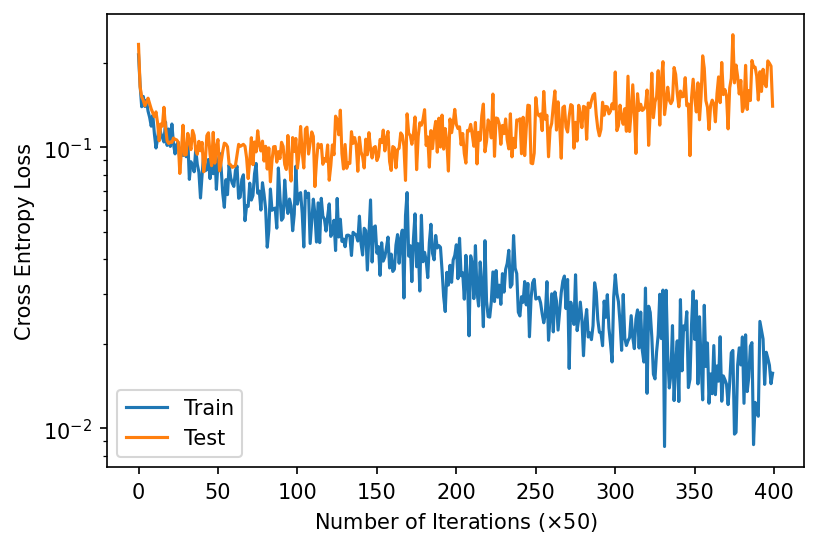

In [ ]:
plt.figure(dpi = 150)
# plt.title('Base CNN Log Loss')
plt.xlabel(r'Number of Iterations ($\times 50$)')
plt.ylabel('Cross Entropy Loss')
plt.semilogy(model.loss_log, label = 'Train')
plt.semilogy(model.loss_log2, label = 'Test')
plt.legend()

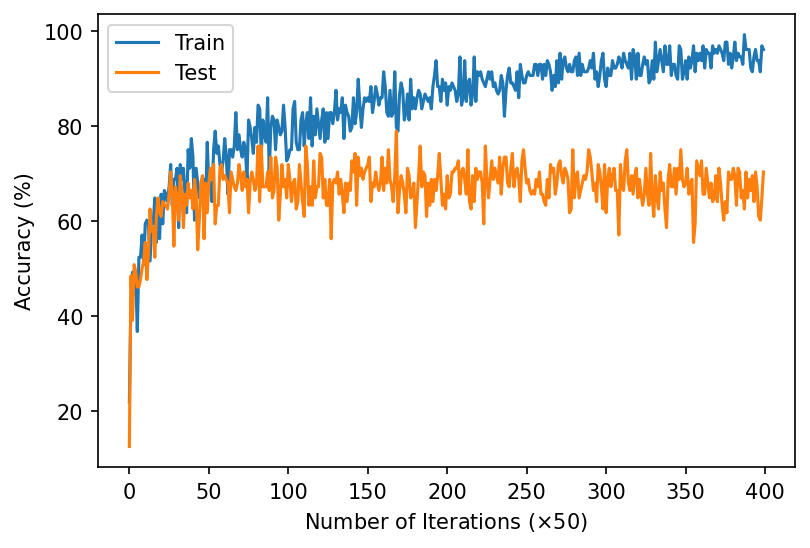

In [ ]:
plt.figure(dpi = 150)
# plt.title('Base CNN Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel(r'Number of Iterations ($\times 50$)')
plt.plot(np.array(model.acc_log) * 100, label = 'Train')
plt.plot(np.array(model.acc_log2) * 100, label = 'Test')
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix (Test Data)')

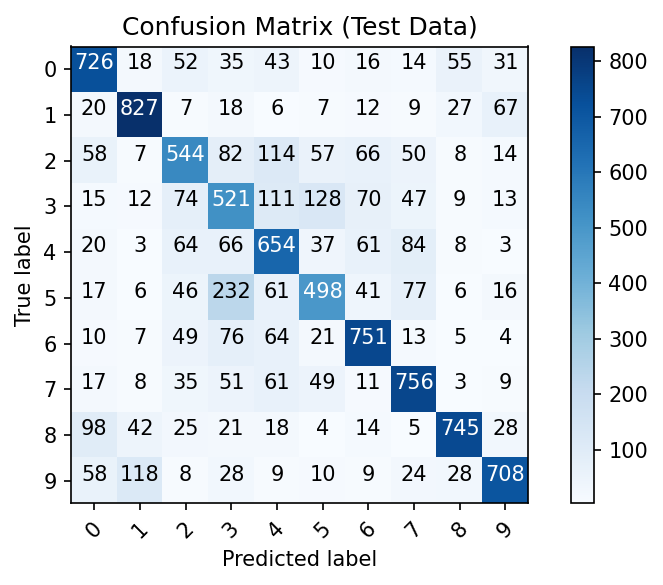

In [ ]:
outputs = model.predict(opt_params, imgs_test)
pred_class = np.argmax(outputs,1)
true_class = np.argmax(labels_test,1)
M = confusion_matrix(true_class, pred_class)
plt.figure(dpi = 150)
plot_confusion_matrix(M, classes=np.arange(10), normalize=False)
plt.title('Confusion Matrix (Test Data)')